In [1]:
import torch
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F

In [2]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288 # replicated

In [3]:
from core.getdata import *
from core.dataset import *

<h3>Example of GetData</h3>

In [4]:
TNFib1 = GetData(ligands[0], polarization[1], replicas, size)
TNFib1.X.shape

(1288, 98)

<h3>Example of Dataset</h3>

In [5]:
data = Dataset(ligands, polarization, replicas, size)

In [6]:
%%time
for _ in data:
    pass

Wall time: 37 ms


In [7]:
data.data.shape

(69552, 98, 1)

In [8]:
print(type(data.data), type(data.labels))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [9]:
print(data.labels, data.labels.shape) #labels are multi-hot encoded

[0 0 0 ... 8 8 8] (69552,)


<h3>Initializing Dataloaders</h3>

In [10]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [11]:
X_len, test_len = int(len(data.data) * 0.9), int(len(data.data) * 0.1)
train_len, val_len = int(X_len * 0.9), int(X_len * 0.1)
print(X_len, test_len, train_len, val_len) #lengths
print(X_len + test_len, len(data.data))

62596 6955 56336 6259
69551 69552


In [12]:
training_data = data.data.reshape(data.data.shape[0], data.data.shape[1], 1) #adds extra dimension

In [13]:
data.data[1000].shape
len(data)

69552

In [14]:
dataset_X, dataset_val = torch.utils.data.random_split(data, [X_len, test_len + 1]) # need separate data and labels for LSTM?

In [15]:
dataloader_train = torch.utils.data.DataLoader(dataset_X, batch_size=64, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=True)

In [16]:
print(len(dataloader_train), len(dataloader_val), len(dataloader_train) + len(dataloader_val))
###
#data[0:10]

979 109 1088


<h3>Model Training</h3>

In [17]:
from core.network import *
from core.trainer import *

In [18]:
torch.cuda.is_available()

True

In [19]:
#model parameters
input_size = 1
hidden_sizes = 98
output_size = 9

#training parameters
n_epochs = 70
batch_size = 64
learning_rate = 1e-3

In [20]:
model = LSTM(input_size, hidden_sizes, output_size, num_layers=2, device="cuda:0")
model.train()

LSTM(
  (lstm): LSTM(1, 98, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=98, out_features=9, bias=True)
)

In [21]:
trainer = LSTMTrainer(model=model, device="cuda:0")

In [22]:
trainer.train(dataloader_train, dataloader_val, batch_size=batch_size, n_epochs=n_epochs)

  1%|█▏                                                                                 | 1/70 [00:09<10:55,  9.50s/it]

Epoch 001: | Training Loss: 2.1545895620556483 | Validation Loss: 2.111291574775626


  3%|██▎                                                                                | 2/70 [00:18<10:43,  9.46s/it]

Epoch 002: | Training Loss: 2.17296431951065 | Validation Loss: 2.0825369303379584


  4%|███▌                                                                               | 3/70 [00:30<11:43, 10.49s/it]

Epoch 003: | Training Loss: 2.142123176201615 | Validation Loss: 2.0690393863467995


  6%|████▋                                                                              | 4/70 [00:43<12:34, 11.43s/it]

Epoch 004: | Training Loss: 2.107806025169965 | Validation Loss: 2.2039303538996147


  7%|█████▉                                                                             | 5/70 [01:00<14:43, 13.60s/it]

Epoch 005: | Training Loss: 2.192734024254367 | Validation Loss: 2.194481123478041


  9%|███████                                                                            | 6/70 [01:18<15:57, 14.97s/it]

Epoch 006: | Training Loss: 2.0856007816112077 | Validation Loss: 1.9823835847574636


 10%|████████▎                                                                          | 7/70 [01:36<16:43, 15.92s/it]

Epoch 007: | Training Loss: 1.8460723500207934 | Validation Loss: 1.8116059226727268


 11%|█████████▍                                                                         | 8/70 [01:54<17:08, 16.59s/it]

Epoch 008: | Training Loss: 1.7467087043318004 | Validation Loss: 1.707074300958476


 13%|██████████▋                                                                        | 9/70 [02:12<17:09, 16.88s/it]

Epoch 009: | Training Loss: 1.685503891831886 | Validation Loss: 1.6552493889397437


 14%|███████████▋                                                                      | 10/70 [02:29<17:11, 17.18s/it]

Epoch 010: | Training Loss: 1.6096173309330069 | Validation Loss: 1.5993773543506586


 16%|████████████▉                                                                     | 11/70 [02:47<17:00, 17.29s/it]

Epoch 011: | Training Loss: 1.585314252403345 | Validation Loss: 1.5871533330427396


 17%|██████████████                                                                    | 12/70 [03:04<16:45, 17.33s/it]

Epoch 012: | Training Loss: 1.6770267921278255 | Validation Loss: 1.6138687363458335


 19%|███████████████▏                                                                  | 13/70 [03:22<16:30, 17.38s/it]

Epoch 013: | Training Loss: 1.6649298855427945 | Validation Loss: 1.8062676781908087


 20%|████████████████▍                                                                 | 14/70 [03:40<16:19, 17.49s/it]

Epoch 014: | Training Loss: 1.7262490890364603 | Validation Loss: 1.6277276638450973


 21%|█████████████████▌                                                                | 15/70 [03:57<16:03, 17.52s/it]

Epoch 015: | Training Loss: 1.579219785968909 | Validation Loss: 1.5798967311141687


 23%|██████████████████▋                                                               | 16/70 [04:15<15:50, 17.61s/it]

Epoch 016: | Training Loss: 1.6167361233402444 | Validation Loss: 1.5716828545299144


 24%|███████████████████▉                                                              | 17/70 [04:33<15:46, 17.87s/it]

Epoch 017: | Training Loss: 1.535926694645945 | Validation Loss: 1.5371449453021409


 26%|█████████████████████                                                             | 18/70 [04:51<15:25, 17.79s/it]

Epoch 018: | Training Loss: 1.4863130353444443 | Validation Loss: 1.5284414039839298


 27%|██████████████████████▎                                                           | 19/70 [05:09<15:07, 17.80s/it]

Epoch 019: | Training Loss: 1.4495611181054588 | Validation Loss: 1.477454117678721


 29%|███████████████████████▍                                                          | 20/70 [05:26<14:40, 17.61s/it]

Epoch 020: | Training Loss: 1.4117460820721168 | Validation Loss: 1.43075087311071


 30%|████████████████████████▌                                                         | 21/70 [05:43<14:19, 17.53s/it]

Epoch 021: | Training Loss: 1.3772612044224335 | Validation Loss: 1.3891040513274866


 31%|█████████████████████████▊                                                        | 22/70 [06:01<14:01, 17.53s/it]

Epoch 022: | Training Loss: 1.3468762393260758 | Validation Loss: 1.374990468725152


 33%|██████████████████████████▉                                                       | 23/70 [06:19<13:46, 17.58s/it]

Epoch 023: | Training Loss: 1.317644688946721 | Validation Loss: 1.3451949970437846


 34%|████████████████████████████                                                      | 24/70 [06:36<13:31, 17.63s/it]

Epoch 024: | Training Loss: 1.287679886184747 | Validation Loss: 1.3254691165521604


 36%|█████████████████████████████▎                                                    | 25/70 [06:54<13:15, 17.68s/it]

Epoch 025: | Training Loss: 1.260370056585345 | Validation Loss: 1.2888272486695456


 37%|██████████████████████████████▍                                                   | 26/70 [07:12<12:59, 17.73s/it]

Epoch 026: | Training Loss: 1.2346225546499803 | Validation Loss: 1.2630082193864596


 39%|███████████████████████████████▋                                                  | 27/70 [07:29<12:38, 17.64s/it]

Epoch 027: | Training Loss: 1.2084483859244357 | Validation Loss: 1.2467678451756818


 40%|████████████████████████████████▊                                                 | 28/70 [07:47<12:17, 17.56s/it]

Epoch 028: | Training Loss: 1.1861292688790575 | Validation Loss: 1.2430484141778508


 41%|█████████████████████████████████▉                                                | 29/70 [08:04<12:00, 17.58s/it]

Epoch 029: | Training Loss: 1.1686314121573647 | Validation Loss: 1.2299009135010046


 43%|███████████████████████████████████▏                                              | 30/70 [08:22<11:44, 17.62s/it]

Epoch 030: | Training Loss: 1.14763091679613 | Validation Loss: 1.211547084904592


 44%|████████████████████████████████████▎                                             | 31/70 [08:41<11:36, 17.85s/it]

Epoch 031: | Training Loss: 1.126104322712073 | Validation Loss: 1.2128767037610395


 46%|█████████████████████████████████████▍                                            | 32/70 [08:59<11:20, 17.92s/it]

Epoch 032: | Training Loss: 1.1083072839158306 | Validation Loss: 1.1802998250777568


 47%|██████████████████████████████████████▋                                           | 33/70 [09:16<10:54, 17.70s/it]

Epoch 033: | Training Loss: 1.0874265657016766 | Validation Loss: 1.1755205250661307


 49%|███████████████████████████████████████▊                                          | 34/70 [09:33<10:29, 17.50s/it]

Epoch 034: | Training Loss: 1.0601029998191895 | Validation Loss: 1.138795224898452


 50%|█████████████████████████████████████████                                         | 35/70 [09:50<10:12, 17.51s/it]

Epoch 035: | Training Loss: 1.0355511027349271 | Validation Loss: 1.1568638157407078


 51%|██████████████████████████████████████████▏                                       | 36/70 [10:08<09:57, 17.56s/it]

Epoch 036: | Training Loss: 1.0165459243951707 | Validation Loss: 1.1349351559210261


 53%|███████████████████████████████████████████▎                                      | 37/70 [10:26<09:39, 17.55s/it]

Epoch 037: | Training Loss: 0.997131400381094 | Validation Loss: 1.1166474671538817


 54%|████████████████████████████████████████████▌                                     | 38/70 [10:43<09:19, 17.47s/it]

Epoch 038: | Training Loss: 0.9644070430844262 | Validation Loss: 1.1040309623840752


 56%|█████████████████████████████████████████████▋                                    | 39/70 [11:00<09:03, 17.52s/it]

Epoch 039: | Training Loss: 0.9401747833355211 | Validation Loss: 1.089195248183854


 57%|██████████████████████████████████████████████▊                                   | 40/70 [11:18<08:47, 17.59s/it]

Epoch 040: | Training Loss: 0.9129035238469585 | Validation Loss: 1.0958354281722953


 59%|████████████████████████████████████████████████                                  | 41/70 [11:36<08:31, 17.62s/it]

Epoch 041: | Training Loss: 0.8959024030414616 | Validation Loss: 1.055665877434092


 60%|█████████████████████████████████████████████████▏                                | 42/70 [11:53<08:12, 17.59s/it]

Epoch 042: | Training Loss: 0.8650982447798089 | Validation Loss: 1.0475100207766261


 61%|██████████████████████████████████████████████████▎                               | 43/70 [12:11<07:56, 17.66s/it]

Epoch 043: | Training Loss: 0.846039993922484 | Validation Loss: 1.0433896801887301


 63%|███████████████████████████████████████████████████▌                              | 44/70 [12:29<07:38, 17.63s/it]

Epoch 044: | Training Loss: 0.82056654906005 | Validation Loss: 1.017802608669351


 64%|████████████████████████████████████████████████████▋                             | 45/70 [12:47<07:23, 17.73s/it]

Epoch 045: | Training Loss: 0.8094930338603848 | Validation Loss: 0.9793694385694801


 66%|█████████████████████████████████████████████████████▉                            | 46/70 [13:04<07:04, 17.70s/it]

Epoch 046: | Training Loss: 0.7841724313498761 | Validation Loss: 0.9754935180375336


 67%|███████████████████████████████████████████████████████                           | 47/70 [13:22<06:49, 17.79s/it]

Epoch 047: | Training Loss: 0.7484783955808801 | Validation Loss: 0.9694356803500325


 69%|████████████████████████████████████████████████████████▏                         | 48/70 [13:40<06:28, 17.68s/it]

Epoch 048: | Training Loss: 0.7379579888361832 | Validation Loss: 0.9659309146601126


 70%|█████████████████████████████████████████████████████████▍                        | 49/70 [13:58<06:12, 17.74s/it]

Epoch 049: | Training Loss: 0.7196557971138023 | Validation Loss: 0.9514028429985046


 71%|██████████████████████████████████████████████████████████▌                       | 50/70 [14:15<05:54, 17.73s/it]

Epoch 050: | Training Loss: 0.690947561999507 | Validation Loss: 0.9446111660484874


 73%|███████████████████████████████████████████████████████████▋                      | 51/70 [14:33<05:37, 17.74s/it]

Epoch 051: | Training Loss: 0.6665677306783577 | Validation Loss: 0.9236915291996177


 74%|████████████████████████████████████████████████████████████▉                     | 52/70 [14:51<05:20, 17.79s/it]

Epoch 052: | Training Loss: 0.6595961726722483 | Validation Loss: 0.9331685427678834


 76%|██████████████████████████████████████████████████████████████                    | 53/70 [15:09<05:04, 17.94s/it]

Epoch 053: | Training Loss: 0.6358375330136916 | Validation Loss: 0.9083421952133879


 77%|███████████████████████████████████████████████████████████████▎                  | 54/70 [15:27<04:46, 17.92s/it]

Epoch 054: | Training Loss: 0.6477697989365906 | Validation Loss: 0.8962703377281854


 79%|████████████████████████████████████████████████████████████████▍                 | 55/70 [15:45<04:27, 17.85s/it]

Epoch 055: | Training Loss: 0.5980614620556749 | Validation Loss: 0.909940337916033


 80%|█████████████████████████████████████████████████████████████████▌                | 56/70 [16:02<04:06, 17.62s/it]

Epoch 056: | Training Loss: 0.6311762466859282 | Validation Loss: 1.078737534514261


 81%|██████████████████████████████████████████████████████████████████▊               | 57/70 [16:20<03:49, 17.62s/it]

Epoch 057: | Training Loss: 0.6269920066501318 | Validation Loss: 0.8805207276563032


 83%|███████████████████████████████████████████████████████████████████▉              | 58/70 [16:37<03:30, 17.57s/it]

Epoch 058: | Training Loss: 0.5421938967260326 | Validation Loss: 0.846456604813217


 84%|█████████████████████████████████████████████████████████████████████             | 59/70 [16:53<03:08, 17.11s/it]

Epoch 059: | Training Loss: 0.5438556369922987 | Validation Loss: 0.8575060332040174


 86%|██████████████████████████████████████████████████████████████████████▎           | 60/70 [17:05<02:35, 15.57s/it]

Epoch 060: | Training Loss: 0.5301788309256074 | Validation Loss: 0.8734887482923105


 87%|███████████████████████████████████████████████████████████████████████▍          | 61/70 [17:17<02:09, 14.42s/it]

Epoch 061: | Training Loss: 0.5200394160961836 | Validation Loss: 0.8899061474778237


 89%|████████████████████████████████████████████████████████████████████████▋         | 62/70 [17:28<01:48, 13.59s/it]

Epoch 062: | Training Loss: 0.5208973580318769 | Validation Loss: 0.8445797414954649


 90%|█████████████████████████████████████████████████████████████████████████▊        | 63/70 [17:41<01:32, 13.14s/it]

Epoch 063: | Training Loss: 0.49557389465062684 | Validation Loss: 0.8564884985258819


 91%|██████████████████████████████████████████████████████████████████████████▉       | 64/70 [17:53<01:16, 12.82s/it]

Epoch 064: | Training Loss: 0.4850625796081827 | Validation Loss: 0.8231980981083091


 93%|████████████████████████████████████████████████████████████████████████████▏     | 65/70 [18:05<01:02, 12.58s/it]

Epoch 065: | Training Loss: 0.48904347689146893 | Validation Loss: 0.9101233766713274


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 66/70 [18:17<00:49, 12.36s/it]

Epoch 066: | Training Loss: 0.45282859158101924 | Validation Loss: 0.8389719385619557


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 67/70 [18:29<00:36, 12.27s/it]

Epoch 067: | Training Loss: 0.44165905036100694 | Validation Loss: 0.8493681175446292


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 68/70 [18:40<00:24, 12.16s/it]

Epoch 068: | Training Loss: 0.44239856485387763 | Validation Loss: 0.8882657163733736


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 69/70 [18:52<00:12, 12.06s/it]

Epoch 069: | Training Loss: 0.4497324905612252 | Validation Loss: 0.8313996089160989


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [19:05<00:00, 16.36s/it]

Epoch 070: | Training Loss: 0.4386249764673069 | Validation Loss: 0.9297054450993144


<h3>Evaluation</h3>

In [23]:
torch.cuda.empty_cache()
x_batch, y_batch = dataset_val[0:10000]
# to do : convert x_batch to tensor and send to gpu 
x_batch = torch.tensor(x_batch, device=torch.device("cuda:0"))
y_pred = trainer.model(x_batch)
y_pred = F.softmax(y_pred, dim=1)
# to do : convert to np array and vstack it to y_pred
y_pred = y_pred.detach().cpu().numpy()
y_pred = np.argmax(y_pred, axis=1)
dic = {"y_pred": y_pred, "y_true": y_batch}

df = pd.DataFrame(dic)

In [24]:
df

,y_pred,y_true
0,7,7
1,0,0
2,7,7
3,8,8
4,5,4
...,...,...
6951,2,2
6952,4,6
6953,6,5
6954,5,5


In [33]:
print(f' Accuracy: {sum(df["y_pred"] == df["y_true"])/6956}')

 Accuracy: 0.7340425531914894


In [31]:
import pickle
import os
torch.save(model.state_dict(), 'models/lstm1.pth') # model trained on replicated dataset

<h3>Plots</h3>

In [27]:
import matplotlib.pyplot as plt

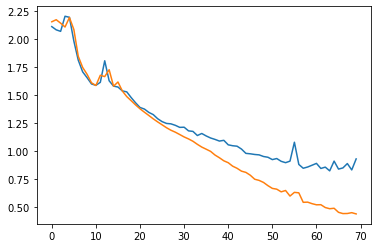

In [28]:
plt.plot(trainer.val_losses)
plt.plot(trainer.train_losses)

Overfitting seems to occur ~50 epochs